In [this notebook](https://github.com/pybites/pybites.github.io-src/blob/master/content/matplotlib-starter.ipynb) I use Matplotlib.pyplot to create simple yet powerful visualizations of PyBites Twitter activity, our blog's tag usage and our website traffic. Lastly I use Google trends to see popularity of various social media.

In [1]:
from collections import Counter, OrderedDict
import csv
import datetime
import itertools
import operator
import random
import re 

import feedparser
from matplotlib import pyplot as plt
import numpy as np
import requests

# to show plots inside our Jupyter notebook
%matplotlib inline

### 1. A simple line chart: how often do we tweet per day? 

For this I ran [our challenge 04 code](http://pybit.es/codechallenge04_review.html) to get a csv with last 200 tweets.

In [2]:
BASE_URL = 'http://projects.bobbelderbos.com/matplotlib/'

def get_csv(url):
    with requests.Session() as s:
        download = s.get(url)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        return list(cr)[1:]
        
def get_dates(csv):
    for row in reversed(csv):
        yield row[1].split()[0]

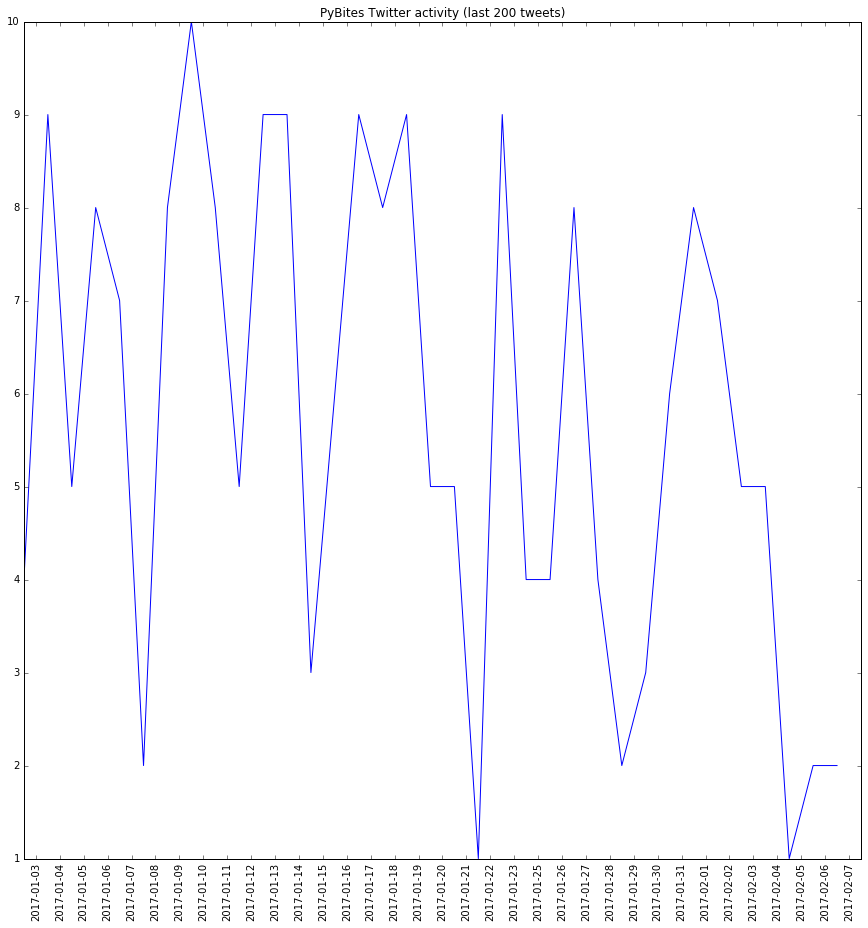

In [3]:
pybites_csv = get_csv('{}pybites.csv'.format(BASE_URL))
c = Counter(list(get_dates(pybites_csv)))
c_sorted = sorted(c.items(), key=operator.itemgetter(0))
labels, values = zip(*c_sorted)
indexes = np.arange(len(labels))
width = 1

plt.plot(indexes, values)
#plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)

fig = plt.gcf()
fig.set_size_inches(15,15)

plt.title('PyBites Twitter activity (last 200 tweets)')
plt.show() # plt.savefig('file.png') to save to file

### 2. Bar chart / distribution of average number of tags PyBites

Lets get our feed and make a histogram of the amount of tags used per article.

In [4]:
our_feed = feedparser.parse('http://pybit.es/feeds/all.rss.xml')

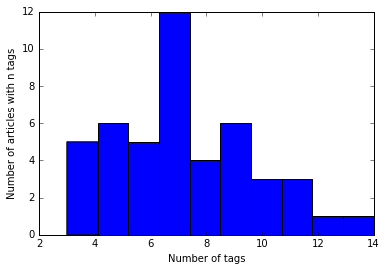

In [5]:
tag_count = [len(entry['tags']) for entry in our_feed['entries']]
plt.hist(tag_count)
plt.xlabel("Number of tags")
plt.ylabel("Number of articles with n tags")
plt.show()

### 3. Scatterplot of Number of shares vs number of visits PyBites 

A scatterplot is good for visualizing relationship. See [my Brexit analysis](https://github.com/bbelderbos/brexit-pandas/blob/master/brexit_demographics.ipynb) for examples, there I related number of leave vs stay votes with demographics (age, education, income, etc.)

In [6]:
top_shares_csv = get_csv('{}TopSharingContent.csv'.format(BASE_URL))
top_visit_csv = get_csv('{}TopVisitContent.csv'.format(BASE_URL))
visits = dict((row[0], row[3]) for row in top_visit_csv)

In [7]:
# take articles with at least one share
pages, shares = zip(*dict((row[0], row[3]) for row in top_shares_csv if int(row[3]) > 1).items())
visits = [visits.get(page, 0) for page in pages]

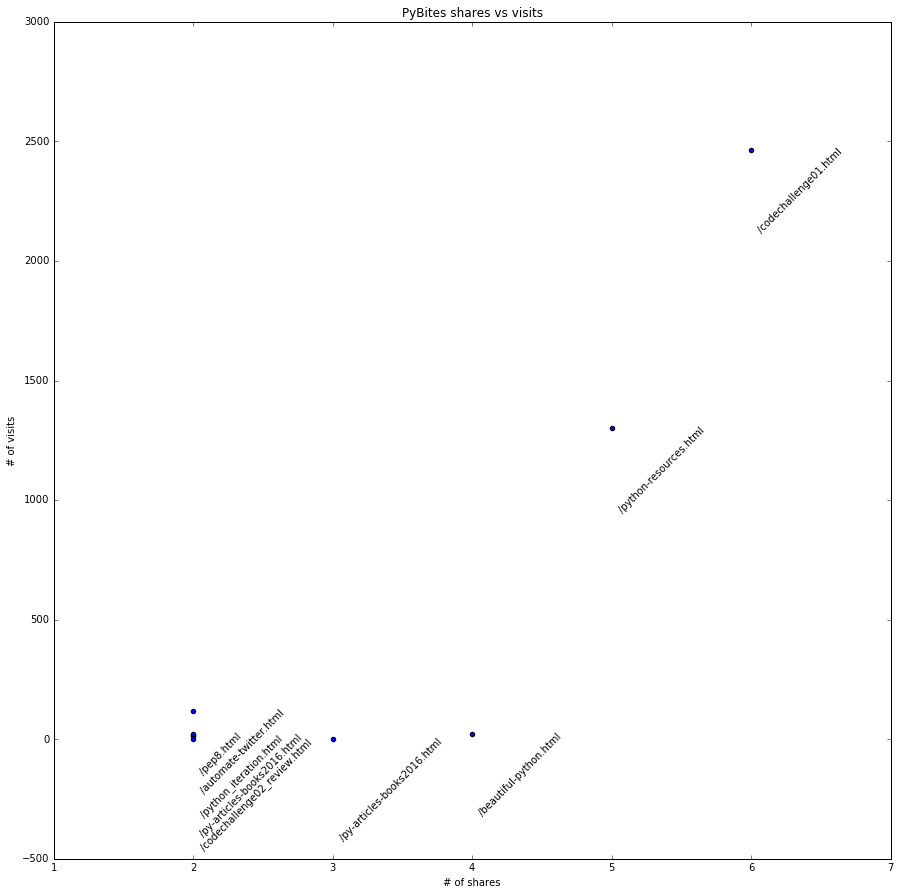

In [8]:
url = re.compile(r'.*pybit.es(/.*?.html).*').sub

plt.scatter(shares, visits)
for page, share, visit in zip(pages, shares, visits):
    plt.annotate(url(r'\1', page), xy=(share, visit),
                xytext=(5, -5), 
                textcoords='offset points', rotation=45)
plt.title('PyBites shares vs visits')
plt.xlabel('# of shares')
plt.ylabel('# of visits')

fig = plt.gcf()
fig.set_size_inches(15, 15)

plt.show()

### 4. Multi-line plot of social media interest rates (Google Trends)

Google Trends lets you measure 'Interest over time':

> Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. Likewise a score of 0 means the term was less than 1% as popular as the peak.

Twitter example [here](https://www.google.com/trends/explore?q=twitter). In the next cell I download this for a couple of big social media and aggregate the results, plotting each service. 

In [9]:
SOCIAL_MEDIA = 'facebook instagram linkedin pinterest reddit skype twitter whatsapp'.split()
THIS_YEAR = datetime.datetime.now().year

def get_stats(soc_media):
    url = '{}{}.csv'.format(BASE_URL, soc_media)
    data = dict(get_csv(url)[2:])
    for year, days in itertools.groupby(sorted(data), lambda date: date[:4]):
        if int(year) < THIS_YEAR:
            days = list(days)
            yield year, sum(int(data.get(d, 0)) for d in days) / len(days)

soc_med_stats = {}
for sm in SOCIAL_MEDIA:
    res = OrderedDict(list(get_stats(sm)))
    soc_med_stats[sm] = res

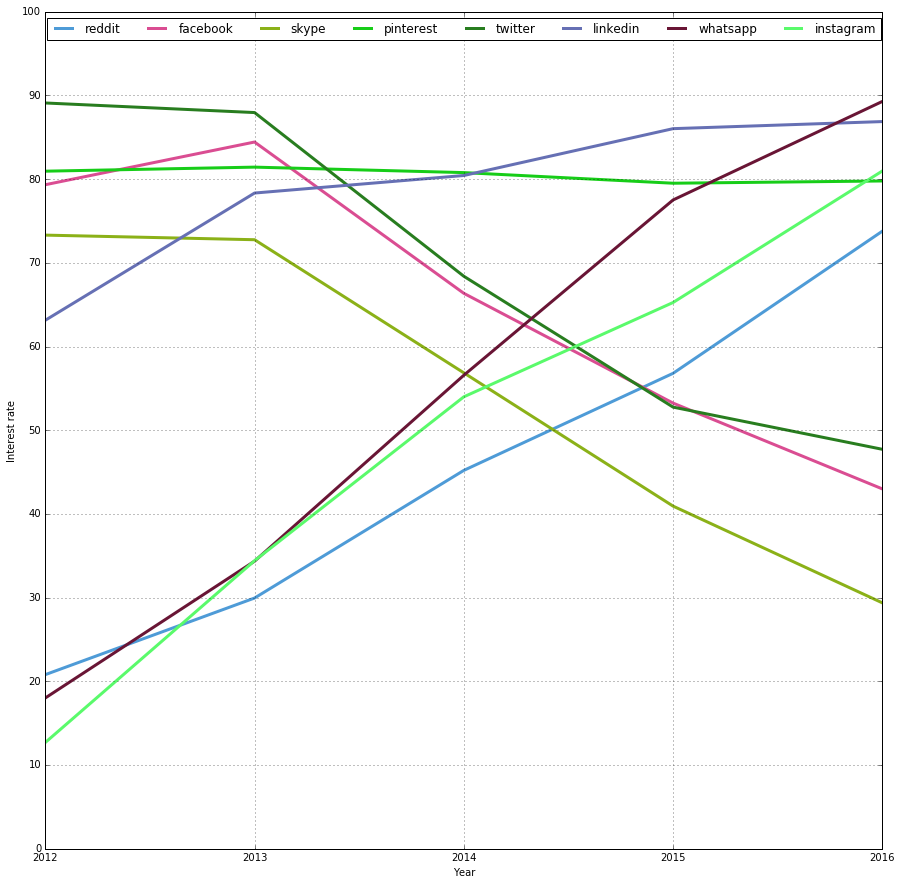

In [13]:
def get_random_color():
    """http://stackoverflow.com/questions/13998901/generating-a-random-hex-color-in-python"""
    r = lambda: random.randint(0,255)
    yield '#%02X%02X%02X' % (r(),r(),r())

years = list(soc_med_stats[SOCIAL_MEDIA[0]].keys())

plt.figure()
fig = plt.gcf()
fig.set_size_inches(15, 15)
for sm, stats in soc_med_stats.items():
    plt.plot(list(stats.keys()), list(stats.values()), label=sm, lw=3, color=next(get_random_color()))
plt.xlim(2012, 2016)
plt.ylim(0, 100)
plt.xticks(range(2012, 2017), ['2012', '2013', '2014', '2015', '2016'])
plt.yticks(range(0,101,10))
plt.xlabel('Year')
plt.ylabel('Interest rate')
plt.legend(loc='upper center', ncol=len(soc_med_stats))
plt.grid(True)
plt.show()

Amazing: clearly interest in [Instagram](https://www.google.com/trends/explore?q=instagram), [Reddit](https://www.google.com/trends/explore?q=reddit) and [Whatsapp](https://www.google.com/trends/explore?q=whatsapp)  grew last couple of years (again this is just one source: Google Trends)

## 5. Your turn

Challenge: make a Programming Language Ranking like [Redmonk](http://redmonk.com/sogrady/2016/02/19/language-rankings-1-16/) or [PYPL](http://pypl.github.io/PYPL.html) 

(no hurries ... we probably will put this as one of the weekly challenges soon ...)

### Training

A good video tutorial on this subject is Randy Olson's [Data Visualization Basics with Python](http://shop.oreilly.com/product/0636920046592.do)